In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import math
import warnings
import time

In [2]:
# 忽略 PerformanceWarning
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

In [3]:
# 读取数据
df1 = pd.read_csv('data/smci_sorted.csv')

# 自定义输入变量
features = ['DPRIME', 'Close', 'Volume', 'Open', 'High', 'Low']
target = 'Close'

# 数据归一化
min_max_scaler = preprocessing.MinMaxScaler()
df0 = min_max_scaler.fit_transform(df1[features])  # 只对选定的特征进行归一化
df = pd.DataFrame(df0, columns=features)

# 创建滞后特征
def create_lag_features(data, features, lag=90):
    lagged_data = pd.DataFrame(index=data.index)
    for feature in features:
        for i in range(1, lag + 1):
            lagged_data[f'{feature}_lag_{i}'] = data[feature].shift(i)
    return pd.concat([data, lagged_data], axis=1)

# 生成滞后特征
data_lagged = create_lag_features(df, features, lag=90)
data_lagged = data_lagged.dropna()  # 删除包含缺失值的行

# 定义特征和目标变量
X = data_lagged.drop(columns=[target])
y = data_lagged[target]

# 数据标准化
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# 记录开始时间
start_time = time.time()

# 滑动窗口预测
window_size = 90  # 滑动窗口大小
test_size = 10    # 每次预测10天
predictions = []
actuals = []

for i in range(window_size, len(X_scaled) - test_size + 1, test_size):
    X_train = X_scaled[i - window_size:i]
    y_train = y.values[i - window_size:i]
    X_test = X_scaled[i:i + test_size]
    y_test = y.values[i:i + test_size]
    
    # 训练随机森林模型
    rf = RandomForestRegressor()
    model = rf.fit(X_train, y_train)
    
    # 在测试集上的预测
    y_test_predict = model.predict(X_test)
    predictions.extend(y_test_predict)
    actuals.extend(y_test)

# 记录结束时间并输出运行时间
end_time = time.time()
print('运行时间（秒）:', end_time - start_time)

运行时间（秒）: 1936.8307313919067


In [7]:
# 检查 predictions 和 actuals 的类型
print(f'Type of predictions: {type(predictions)}')
print(f'Type of actuals: {type(actuals)}')
print(f'Shape of predictions: {predictions.shape}')
print(f'Shape of actuals: {actuals.shape}')

Type of predictions: <class 'numpy.ndarray'>
Type of actuals: <class 'numpy.ndarray'>
Shape of predictions: (2330, 1)
Shape of actuals: (2330, 1)


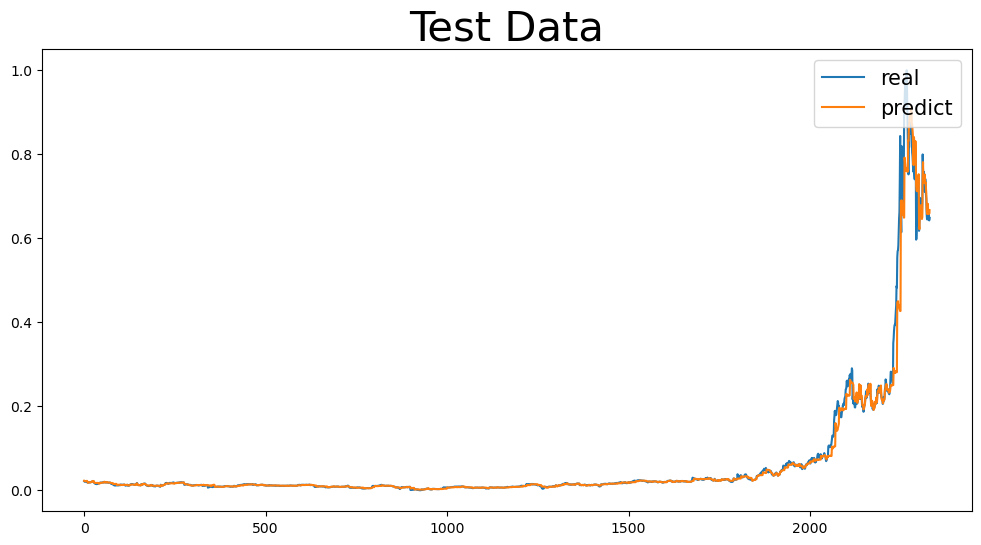

In [12]:
# 绘制实际值和预测值的对比图
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='real')
plt.plot(predictions, label='predict')
plt.legend(loc='upper right', fontsize=15)
plt.title("Test Data", fontsize=30)
plt.show()

In [13]:
# 创建临时数组，只包含目标特征列
temp_pred = np.zeros((predictions.shape[0], len(features)))
temp_act = np.zeros((actuals.shape[0], len(features)))

# 将预测值和实际值放入临时数组的目标列中
temp_pred[:, features.index(target)] = predictions.flatten()
temp_act[:, features.index(target)] = actuals.flatten()

# 打印填充预测值和实际值后的临时数组
print(f'Temp pred array (first 5 rows):\n{temp_pred[:5]}')
print(f'Temp act array (first 5 rows):\n{temp_act[:5]}')

Temp pred array (first 5 rows):
[[0.         0.02257595 0.         0.         0.         0.        ]
 [0.         0.02237619 0.         0.         0.         0.        ]
 [0.         0.02221103 0.         0.         0.         0.        ]
 [0.         0.02149589 0.         0.         0.         0.        ]
 [0.         0.02148603 0.         0.         0.         0.        ]]
Temp act array (first 5 rows):
[[0.         0.02181194 0.         0.         0.         0.        ]
 [0.         0.02074939 0.         0.         0.         0.        ]
 [0.         0.0210299  0.         0.         0.         0.        ]
 [0.         0.02021387 0.         0.         0.         0.        ]
 [0.         0.02020537 0.         0.         0.         0.        ]]


In [14]:
# 进行逆归一化，只针对目标特征列
inverse_predictions = min_max_scaler.inverse_transform(temp_pred)[:, features.index(target)]
inverse_actuals = min_max_scaler.inverse_transform(temp_act)[:, features.index(target)]

# 打印逆归一化后的结果
print(f'Inverse predictions (first 10 values): {inverse_predictions[:10]}')
print(f'Inverse actuals (first 10 values): {inverse_actuals[:10]}')

Inverse predictions (first 10 values): [38.2088 37.9738 37.7795 36.9382 36.9266 37.6109 37.8914 37.908  37.8394
 36.2275]
Inverse actuals (first 10 values): [37.31 36.06 36.39 35.43 35.42 36.67 37.16 36.64 35.36 33.32]


In [15]:
print(f'Shape of Inverse predictions: {inverse_predictions.shape}')
print(f'Shape of Inverse actuals: {inverse_actuals.shape}')

Shape of Inverse predictions: (2330,)
Shape of Inverse actuals: (2330,)


测试集上的MAE: 6.53032326523605
测试集上的MSE: 803.6683551757011
测试集上的MAPE: 4.643176470477882


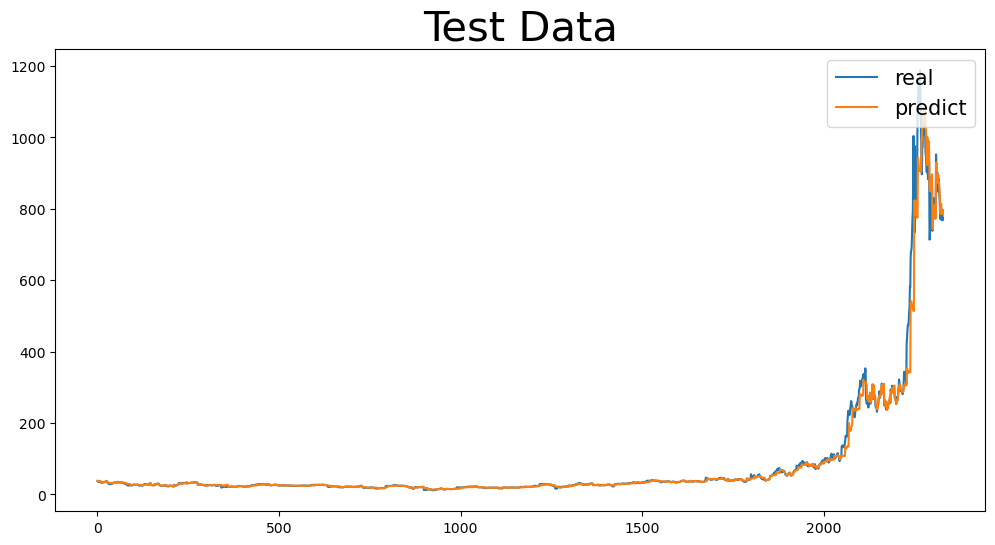

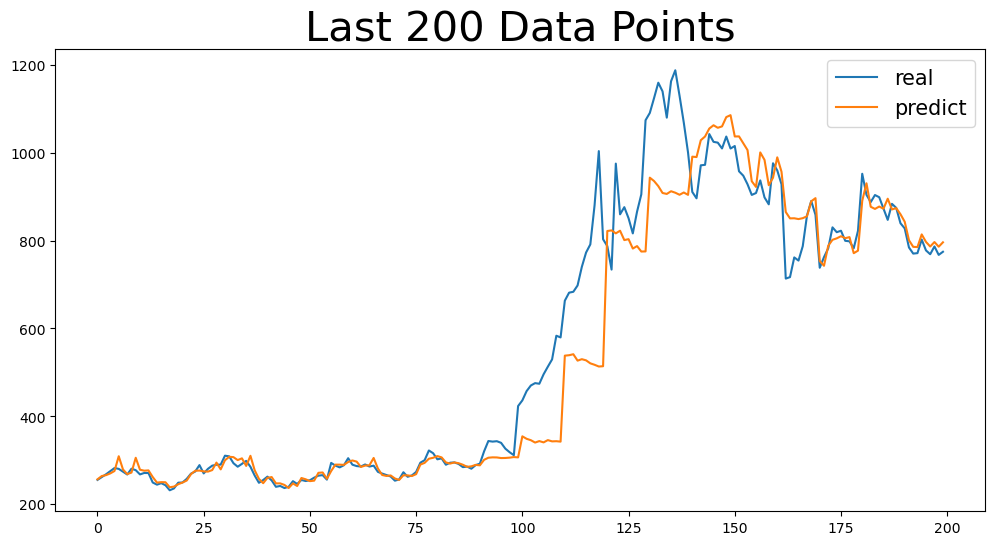

最后10个点的实际值: [827.94 784.51 770.59 771.61 802.52 777.92 769.11 786.86 767.61 774.74]
最后10个点的预测值: [843.1045 801.0269 785.9801 785.3841 814.2624 797.2761 786.7073 796.8588
 786.3001 796.2405]
最后10个点的RMSE: 16.31908675949715


In [16]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

print('测试集上的MAE:', mean_absolute_error(inverse_predictions, inverse_actuals))
print('测试集上的MSE:', mean_squared_error(inverse_predictions, inverse_actuals))
print('测试集上的MAPE:', mape(inverse_predictions, inverse_actuals))

# 绘制实际值和预测值的对比图
plt.figure(figsize=(12, 6))
plt.plot(inverse_actuals, label='real')
plt.plot(inverse_predictions, label='predict')
plt.legend(loc='upper right', fontsize=15)
plt.title("Test Data", fontsize=30)
plt.show()

# 绘制最新200个点的实际值和预测值对比图
plt.figure(figsize=(12, 6))
plt.plot(inverse_actuals[-200:], label='real')
plt.plot(inverse_predictions[-200:], label='predict')
plt.legend(loc='upper right', fontsize=15)
plt.title("Last 200 Data Points", fontsize=30)
plt.show()

# 输出最后10个点的预测值和实际值
print('最后10个点的实际值:', inverse_actuals[-10:])
print('最后10个点的预测值:', inverse_predictions[-10:])

# 计算最后10个点的RMSE
rmse_last_10 = np.sqrt(mean_squared_error(inverse_actuals[-10:], inverse_predictions[-10:]))
print('最后10个点的RMSE:', rmse_last_10)
